<a href="https://colab.research.google.com/github/Rishabh672003/stack-overflow-label-predictor/blob/main/Stack_Overflow_label_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import losses

In [6]:
url = "https://github.com/Rishabh672003/stack-overflow-label-predictor/raw/main/stack_overflow_16k-full.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k-full", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
!
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k-full')

In [7]:
os.listdir(dataset_dir)

['README.md', 'train', 'test']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['java', 'csharp', 'python', 'javascript']

In [9]:
sample_file = os.path.join(train_dir, 'csharp/1.txt')
with open(sample_file) as f:
  print(f.read())

"get the y axis height of webbrowser control document i am trying to get the height of a document in a web browser control...at the moment i'm using the code below but it always returns 622 and i know my documents are all different sizes...private void webcomparesql_documentcompleted(object sender, webbrowserdocumentcompletedeventargs e).        {.            htmldocument htmldoc = webcomparesql.document;.           int scrollhight = htmldoc.window.position.y;.        }...can someone please show me the right way to do this?"



In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k-full/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)
raw_train_ds

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(4):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k-full/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k-full/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [20]:
print("128 ---> ",vectorize_layer.get_vocabulary()[128])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

128 --->  result
 313 --->  source
Vocabulary size: 10000


In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160068 (625.27 KB)
Trainable params: 160068 (625.27 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [24]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=["accuracy"])

In [25]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
r = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[callback],
    epochs=epochs)

Epoch 1/20
200/200 [==============================] - 4s 15ms/step - loss: 1.3795 - accuracy: 0.3348 - val_loss: 1.3694 - val_accuracy: 0.5031
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 1.3533 - accuracy: 0.4589 - val_loss: 1.3351 - val_accuracy: 0.5400
Epoch 3/20
200/200 [==============================] - 1s 7ms/step - loss: 1.3073 - accuracy: 0.5317 - val_loss: 1.2810 - val_accuracy: 0.5769
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 1.2427 - accuracy: 0.5881 - val_loss: 1.2114 - val_accuracy: 0.6363
Epoch 5/20
200/200 [==============================] - 3s 13ms/step - loss: 1.1658 - accuracy: 0.6448 - val_loss: 1.1352 - val_accuracy: 0.6769
Epoch 6/20
200/200 [==============================] - 3s 17ms/step - loss: 1.0868 - accuracy: 0.6888 - val_loss: 1.0610 - val_accuracy: 0.7156
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 1.0121 - accuracy: 0.7147 - val_loss: 0.9934 - val_accuracy: 0.7269
Epo

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.6442 - accuracy: 0.7751
Loss:  0.6442432999610901
Accuracy:  0.7751250267028809


In [27]:
history_dict = r.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

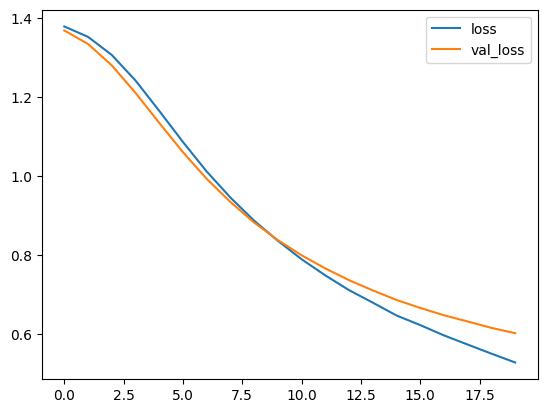

In [28]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

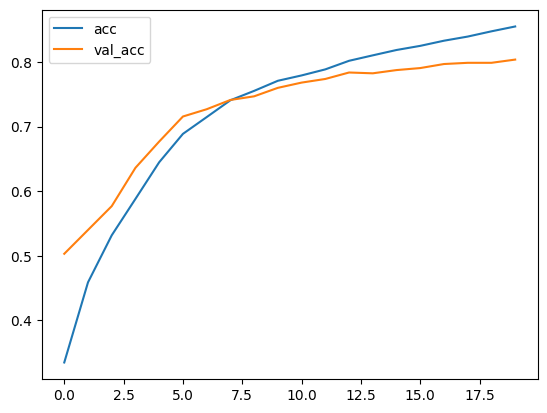

In [29]:
plt.plot(r.history['accuracy'], label = "acc")
plt.plot(r.history['val_accuracy'], label = "val_acc")
plt.legend();

In [30]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 2s 6ms/step - loss: 0.6442 - accuracy: 0.7751
0.7751250267028809


In [48]:
labels = ["Csharp", "Java", "Javascript", "Python"]
examples = [
  "Why can't this generic method return concrete class that implements it's interface?",
  "I have a dictionary of size n and i want to double its size and put 0:0 in the remaining spots",
  "Restsharp 110.2 returns 401 with Basic Authentication",
  "How to make good reproducible pandas examples, a = 12 import pandas as pd",
]

answers = export_model.predict(examples)
print(answers)
for i in range(0,len(examples)):
  label = np.argmax(answers[i])
  print(labels[label])

1/1 [==============================] - 0s 62ms/step
[[0.60096085 0.62375647 0.46885502 0.33413807]
 [0.55880135 0.4948031  0.44409165 0.50182897]
 [0.5399914  0.44318882 0.5769656  0.43883237]
 [0.43677205 0.4689382  0.4822484  0.6285582 ]]
java
Csharp
Javascript
Python


In [32]:
export_model.save('./NLP-model')
!tar -czf ./NLP-model.tar.gz ./NLP-model

250/250 [==============================] - 2s 9ms/step
[[555 391 505 549]
 [479 400 547 574]
 [545 401 499 555]
 [537 393 489 581]]


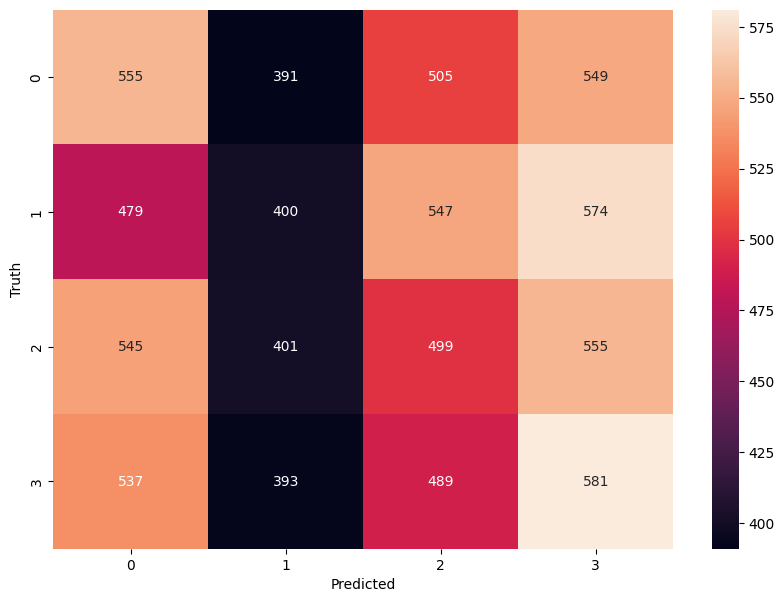

In [33]:
predictions = export_model.predict(raw_test_ds)

predicted_labels = np.argmax(predictions, axis=-1)

actual_labels = []
for _, label in raw_test_ds:
  actual_labels.extend(label.numpy())

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(actual_labels, predicted_labels).numpy()

# Print the confusion matrix
print(confusion_mtx)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
